In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import networkx as nx
import pymc as pm

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
import networkx as nx
import matplotlib.pyplot as plt

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


## Generate random DAG

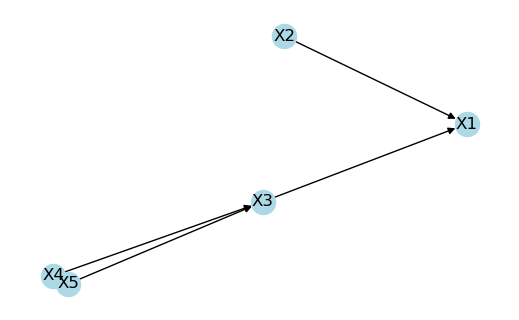

In [2]:
nodes = [f"X{i+1}" for i in range (5)]
p = len(nodes)

plt.figure(figsize = (5, 3))
g_rd = nx.gn_graph(p, seed = 1)
g = nx.DiGraph()
g.add_nodes_from(nodes)

for node_from, node_to in g_rd.edges():
    g.add_edge(nodes[node_from], nodes[node_to])

pos = nx.kamada_kawai_layout(g)
nx.draw(g, pos = pos, with_labels = True, node_color='lightblue')


In [3]:
tpsort = list(nx.topological_sort(g))
print(tpsort)

['X2', 'X4', 'X5', 'X3', 'X1']


## Set parameters and dependencies

In [4]:
# parameters (mean, var)
random.seed(42)
params = {}
nonroot_coefs = {}

for node in nodes:
    parents = [parent for parent in g.predecessors(node)]
    if len(parents) == 0:
        mu = random.uniform(1, 3)
        var = random.uniform(1, 3)
        params[node] = (mu, var)
        
        print(f"{node}: (mean, var) = ({mu:.2f}, {var:.2f})")
    else:
        intercept = np.random.choice([0,1]) # intercept 0 or 1
        coefs = [random.randint(-2, 2) for _ in range(len(parents))] 
        nonroot_coefs[node] = [intercept] + coefs
        
        expression = " + ".join([f"({c})*{pa}" for c, pa in zip(coefs, parents)])
        print(f"{node} = {intercept}+{expression}")

X1 = 1+(-2)*X2 + (-2)*X3
X2: (mean, var) = (2.48, 1.49)
X3 = 0+(-1)*X4 + (-2)*X5
X4: (mean, var) = (2.35, 2.78)
X5: (mean, var) = (1.17, 1.84)


## Functions define
- **bn_model_SNR**: pymc model
- **draw_sample**: Generate data based on a given pymc model

In [5]:
def bn_model_SNR(g, node_params, node_coefs, SNR_dB=10):
    """
    Define a Bayesian network model with specified signal-to-noise ratio (SNR) constraints.

    Parameters:
    - g: A directed acyclic graph (DAG) representing the Bayesian network structure, where nodes represent variables.
    - node_params: A dictionary mapping nodes to their parameters (mean and variance) for Gaussian distributions.
    - node_coefs: A dictionary mapping nodes to their coefficients, indicating linear dependencies on their parents.
    - SNR_dB: Desired signal-to-noise ratio in decibels for the noise added to each non-root node.

    Returns:
    - model: A PyMC model instance representing the Bayesian network.
    - node_params: Updated node_params with calculated means and variances including noise contributions.
    """
    # Obtain a topological sort of the graph to ensure parent nodes are processed before their children.
    tpsort = list(nx.topological_sort(g))
    
    # Initialize a PyMC model context.
    with pm.Model() as model:
        # Dictionary to store PyMC variables for each node.
        particles = {}

        # Iterate over the nodes in topologically sorted order.
        for node in tpsort:
            # Identify the parents of the current node.
            parents = [parent for parent in g.predecessors(node)]
            
            if len(parents) == 0:
                # Handle root nodes: nodes without parents.
                mu, var = node_params[node]
                particles[node] = pm.Normal(node, mu=mu, sigma=np.sqrt(var))
            else:
                # Handle non-root nodes: nodes with one or more parents.
                # Extract and process coefficients for linear dependency on parents.
                coefs = node_coefs[node].copy()
                intercept = coefs.pop(0)
                
                # Initialize variables for linear combination of parent contributions.
                pred = intercept     # Prediction before adding noise
                node_mu = intercept  # Mean of the current node's distribution
                power_signal = 0     # Power of the signal contributed by parent nodes
                
                # Accumulate contributions from parent nodes.
                for i, pa in enumerate(parents):
                    parent_mu, parent_var = node_params[pa]
                    pred += coefs[i] * particles[pa]
                    node_mu += coefs[i] * parent_mu
                    power_signal += (coefs[i] ** 2) * parent_var
                
                # Calculate noise power based on desired SNR.
                power_noise = power_signal / (10 ** (SNR_dB / 10))
                
                # Define noise as a PyMC Normal variable and add it to the prediction.
                noise = pm.Normal(f'{node}_noise', mu=0, sigma=np.sqrt(power_noise))
                particles[node] = pm.Deterministic(node, pred + noise)
                
                # Update the mean and variance parameters for the current node.
                node_var = power_signal + power_noise
                node_params[node] = (node_mu, node_var)
    
    return model, node_params

In [6]:
def draw_sample(bn_model, num_samples = 1000):
    with bn_model:
        trace = pm.sample(num_samples, tune=500, progressbar=False,  random_seed = 42)  
    samples = {}
    for node in nodes:
        samples[node] = trace.posterior[node][0]
    df = pd.DataFrame(samples, columns = nodes)
    
    return df

## Generate BN data

- **Step1**: Define pymc model

In [7]:
model_SNR, node_params_SNR = bn_model_SNR(g = g, 
                                          node_params = params.copy(),
                                          node_coefs = nonroot_coefs, 
                                          SNR_dB = 10)

- **Step2**: Draw sameple from the model

In [8]:
df = draw_sample(bn_model = model_SNR)
df.head(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X2, X4, X5, X3_noise, X1_noise]
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.


,X1,X2,X3,X4,X5
0,5.200489,1.698422,-1.788503,2.232679,0.030589
1,6.767775,3.251933,-7.144619,2.310618,2.346381
2,3.736442,1.917607,-2.428572,2.409173,0.142150


- **Step3**: Check whether the sample mean and variation in the synthetic data are close to the model settings.

In [9]:
# Compare (sample mean, sample var) with (model_mean, model_var)
param_summary = pd.DataFrame({
    "sample_mean": df.mean(),
    "sample_var": df.var()
})
model_means_vars = pd.DataFrame([node_params_SNR[node] for node in nodes], index=nodes, columns=["model_mean", "model_var"])
param_summary = param_summary.join(model_means_vars)
param_summary.round(2)

,sample_mean,sample_var,model_mean,model_var
X1,5.38,53.67,5.44,55.73
X2,2.54,1.54,2.48,1.49
X3,-4.76,10.89,-4.70,11.18
X4,2.38,2.69,2.35,2.78
X5,1.21,1.64,1.17,1.84


## Learn BN from sample data

In [10]:
# Import r package
pandas2ri.activate()
bnlearn = importr("bnlearn")

In [11]:
# Hill climbing algorithm
bn_r = bnlearn.hc(df, restart = 30, perturb = 3)
bn_pd = ro.conversion.rpy2py(bn_r)
bn = dict(zip(bn_pd.names, map(list,list(bn_pd))))
edges = bn['arcs']
edges = (np.asmatrix(edges).reshape(2,-1)).T.tolist()
print(f"Number of edges: {len(edges)}")   

Number of edges: 4


## Compare true network and learned network

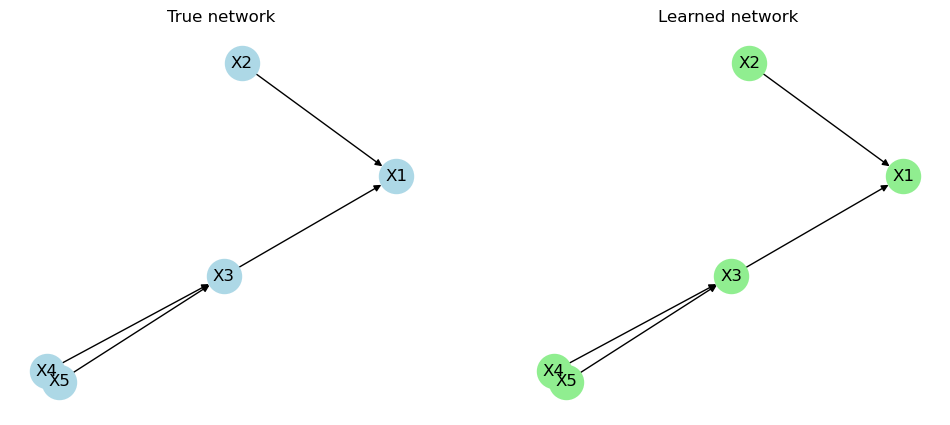

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

# true network
nx.draw(g, pos, with_labels = True, node_color='lightblue',node_size = 600, ax = ax[0])

# learned network
g_learned = nx.DiGraph()
g_learned.add_nodes_from(df.columns.values)
g_learned.add_edges_from(edges)

nx.draw(g_learned, pos, with_labels = True, node_color='lightgreen', node_size = 600, ax = ax[1])

ax[0].set_title("True network")
ax[1].set_title("Learned network");